In [8]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations

from qiskit_aer.noise import (NoiseModel, pauli_error)

from qiskit.circuit.library import UnitaryGate

from matplotlib import ticker
import bitstring
import matplotlib as mpl

import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Bitstream Vera Sans",
#  #   "font.weight": "bold"
# #    "font.sans-serif": "Helvetica",
# })

In [2]:
n = 15
unit, adj = [], []
with open("text/unitary{}.txt".format(n), "r") as file:
    for line in file:
        unit.append(list(map(str, line.strip().split(","))))
with open("text/adjunitary{}.txt".format(n), "r") as file:
    for line in file:
        adj.append(list(map(str, line.strip().split(","))))

angles = np.linspace(0,1,17)[1:16]
print("Angles that we use for the decompositions: ", angles)

Angles that we use for the decompositions:  [0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625
 0.6875 0.75   0.8125 0.875  0.9375]


In [86]:
def U(qc: QuantumCircuit, pos: int, decomp: list, index = 0):
    for i in decomp[index]:
        if i == "h":
            qc.h(pos)
        if i == "z":
            qc.z(pos)
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)

def convert(bin: str):                  #konvertiert den bitstring in decimal, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def iQPE(index: int, shots: int, noise: int):
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "tdg", "t", "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
    
    qr = QuantumRegister(2,"q")
    cbits = ClassicalRegister(3,"c")
    qc = QuantumCircuit(qr, cbits)
    for k in range(3):
        qc.id(0), qc.id(1)
        qc.h(0), qc.x(1)
        for i in range(2**(2-k)):
            U(qc, pos=0, decomp=unit, index=index), U(qc, pos=1, decomp=unit, index=index)
            qc.cx(0,1)
            U(qc, pos=1, decomp=adj, index=index)
            qc.cx(0,1)     
        if k == 1:
            with qc.if_test((0,1)):
                qc.sdg(0)
        else:
            with qc.if_test((0,1)):
                qc.tdg(0)
        with qc.if_test((1,1)):
            qc.sdg(0)
        qc.h(0)
        qc.id(0)
        qc.measure(0,k)
        qc.reset(0), qc.reset(1)

    sim = AerSimulator()
    if noise != 0:
        job = sim.run(qc, noise_model = noise_model, shots=shots)
    else:
        job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

In [4]:
counts = iQPE(0, shots=10000, noise=0)

print(counts.get("101"))

119


In [5]:
x1, y1, y_qec1, err1, err_qec1 = np.loadtxt("text/RotSurfFinal_a.txt", delimiter = ",")
x2, y2, y_qec2, err2, err_qec2 = np.loadtxt("text/RotSurfFinal_a+.txt", delimiter = ",")
x3, y3, y_qec3, err3, err_qec3 = np.loadtxt("text/RotSurfFinal_a++.txt", delimiter = ",")

x1, y1, y_qec1, err1, err_qec1 = list(x1), list(y1), list(y_qec1), list(err1), list(err_qec1)
x2, y2, y_qec2, err2, err_qec2 = list(x2), list(y2), list(y_qec2), list(err2), list(err_qec2)
x3, y3, y_qec3, err3, err_qec3 = list(x3), list(y3), list(y_qec3), list(err3), list(err_qec3)

x2.pop(0), x3.pop(0), y2.pop(0), y3.pop(0), y_qec2.pop(0), y_qec3.pop(0), err2.pop(0), err3.pop(0), err_qec2.pop(0), err_qec3.pop(0)

x = x1+x2+x3
y = y1+y2+y3
y_qec = y_qec1+y_qec2+y_qec3
err = err1+err2+err3
err_qec = err_qec1+err_qec2+err_qec3

err = [i/((400)**0.5) for i in err]
err_qec = [i/((400)**0.5)for i in err_qec]

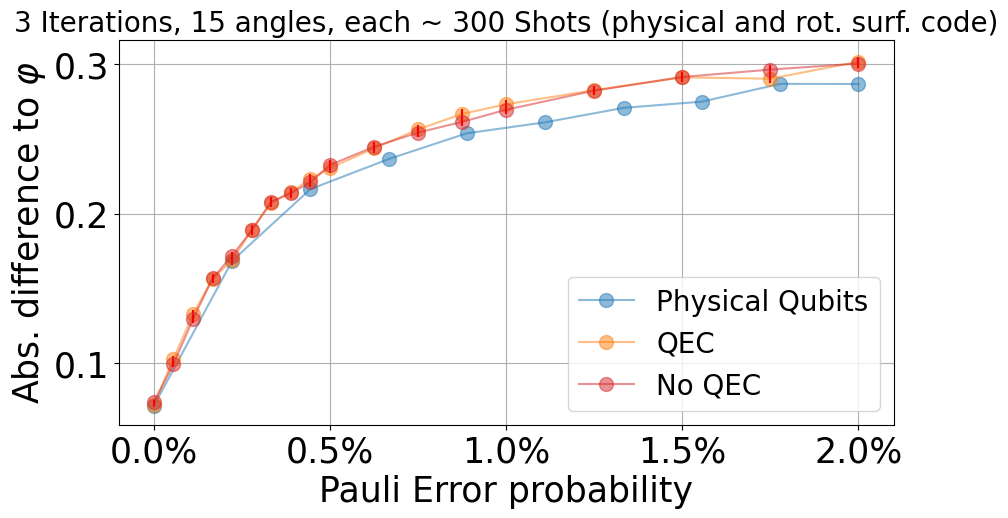

In [9]:
shots = 300
noise = np.linspace(0,0.02,10)
y_phys = []

for t in noise:
    total = 0
    for i, val in enumerate(angles):
        counts = iQPE(i, shots=shots, noise=t)
        for k in counts.keys():
            hmm = convert(k)
            diff = np.abs(hmm-val)
            diff = diff*counts.get(k)
            total += diff
    total = total/(shots*len(angles))
    y_phys.append(total)

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 1))
ax1.plot(noise, y_phys, label="Physical Qubits", marker = ".",markersize = 20, alpha = 0.5)

ax1.plot(x,y_qec, label="QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y_qec, yerr=err_qec, ecolor="red", linestyle="")

ax1.plot(x,y, label="No QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y, yerr=err, ecolor="red", linestyle="")

ax1.set_title(r"3 Iterations, 15 angles, each ~ 300 Shots (physical and rot. surf. code)", fontsize=20)
ax1.set_xlabel("Pauli Error probability", fontsize=25)
ax1.set_ylabel(r"Abs. difference to $\varphi$", fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.grid()
ax1.legend(fontsize=20)
#plt.tight_layout()
plt.show()

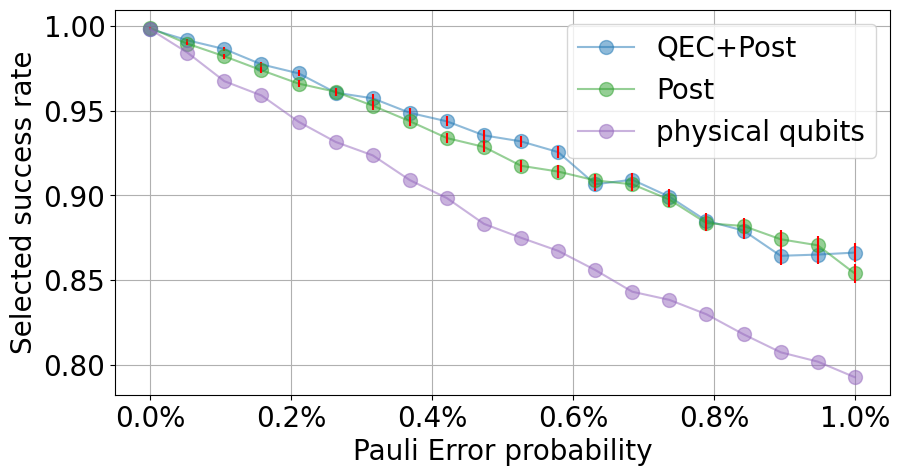

In [104]:
#Succesrate von der dritte Iteration auf den physical qubits

#third = np.array([['t', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h']])     #different decomps given by sk
third = np.array([['t', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg']])

#adj_third = np.array([['h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg']])    #different decomp given by sk
adj_third = np.array([['h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h']])


noise = np.linspace(0,0.01,20)
success = []
shots = 10000

for p in noise:
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "tdg", "t", "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    qr = QuantumRegister(2,"q")
    cbits = ClassicalRegister(1,"c")
    qc = QuantumCircuit(qr, cbits)

    qc.id(0), qc.id(1)
    qc.h(0), qc.x(1)

    U(qc, pos=0, decomp=third), U(qc, pos=1, decomp=third)
    qc.cx(0,1)
    U(qc, pos=1, decomp=adj_third)
    qc.cx(0,1)
    
    qc.tdg(0)

    qc.h(0)
    qc.id(0)
    qc.measure(0,0)

    sim = AerSimulator()

    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    success.append(counts["0"]/shots)

x,zero,one,post,zero_QEC,one_QEC,post_QEC = np.loadtxt("text/FTRotSurf_3rd_f+.txt", delimiter = ",")       #genau wie f, bloß reingezoomt

fig, ax2 = plt.subplots(figsize=(10,5))
ax2.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 1))

y_PS = []
y_no_QEC_PS = []
for i in range(len(x)):
    y_no_QEC_PS.append(zero[i]/(one[i]+zero[i]))
    y_PS.append(zero_QEC[i]/(one_QEC[i]+zero_QEC[i]))

err3, err4 = [], []
for i in y_PS:
    err3.append(np.sqrt((i-i**2)/(10000*(1-post[y_PS.index(i)]))))
for i in y_no_QEC_PS:
    err4.append(np.sqrt((i-i**2)/(10000*(1-post[y_no_QEC_PS.index(i)]))))


ax2.plot(x,y_PS, label="QEC+Post", marker = ".",markersize = 20, alpha = 0.5)
ax2.errorbar(x, y_PS, yerr=err3, ecolor="red", linestyle="")
ax2.plot(x,y_no_QEC_PS, label="Post", marker = ".",markersize = 20, alpha = 0.5)
ax2.errorbar(x, y_no_QEC_PS, yerr=err4, ecolor="red", linestyle="")

ax2.plot(noise, success, label="physical qubits", marker=".",markersize = 20, alpha = 0.5)


ax2.set_xlabel("Pauli Error probability", fontsize=20)
#ax3.set_xlabel("Pauli Error probability", fontsize=20)
ax2.set_ylabel("Selected success rate", fontsize=20)
#ax3.set_ylabel("Success rate", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
#ax3.tick_params(axis='both', which='major', labelsize=20)
ax2.grid()

ax2.legend(fontsize=20)

plt.show()

In [69]:
circ = QuantumCircuit(1)
circ.rz(np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootT = skd(circ)

print(rootT)

instruction = rootT.data

third = np.array([[]])

for i in instruction:
    third = np.append(third,i.name)

print(third)

global phase: 15π/8
   ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐»
q: ┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├»
   └───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘»
«   ┌───┐┌───┐┌─────┐
«q: ┤ T ├┤ H ├┤ Tdg ├
«   └───┘└───┘└─────┘
['t' 'h' 't' 'h' 't' 'h' 'tdg' 'h' 'tdg' 'h' 'tdg' 'h' 't' 'h' 't' 'h'
 'tdg']
